# Imports

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.initializers import RandomNormal
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.models import load_model
import utilities
import seaborn as sns

# GPU Allocation

In [3]:
#### os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

In [ ]:
STORE_Path = "Results/4cls/Res_Fold1"
CHECKPOINTS_Path = STORE_Path+"/checkpoints/"
LOGS_Path = STORE_Path+"/"
PLOTS_Path = STORE_Path+"/plots/"

# create directories
if not os.path.isdir(CHECKPOINTS_Path):
    os.makedirs(CHECKPOINTS_Path)
if not os.path.isdir(PLOTS_Path):
    os.makedirs(PLOTS_Path)

### Supervised

In [3]:
all_paths_df = utilities.make_path_df(["/home/nosabi/Nosheen/UCL-Multiclass/EuroSAT_paths_4cls.txt"])
all_paths_df.sample(5)

,path,label
5220,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/Resid...,Residential
5913,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/Resid...,Residential
2310,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/SeaLa...,SeaLake
7285,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/Pastu...,Pasture
6615,/home/nosabi/Nosheen/WASABI/Data/EuroSAT/Pastu...,Pasture


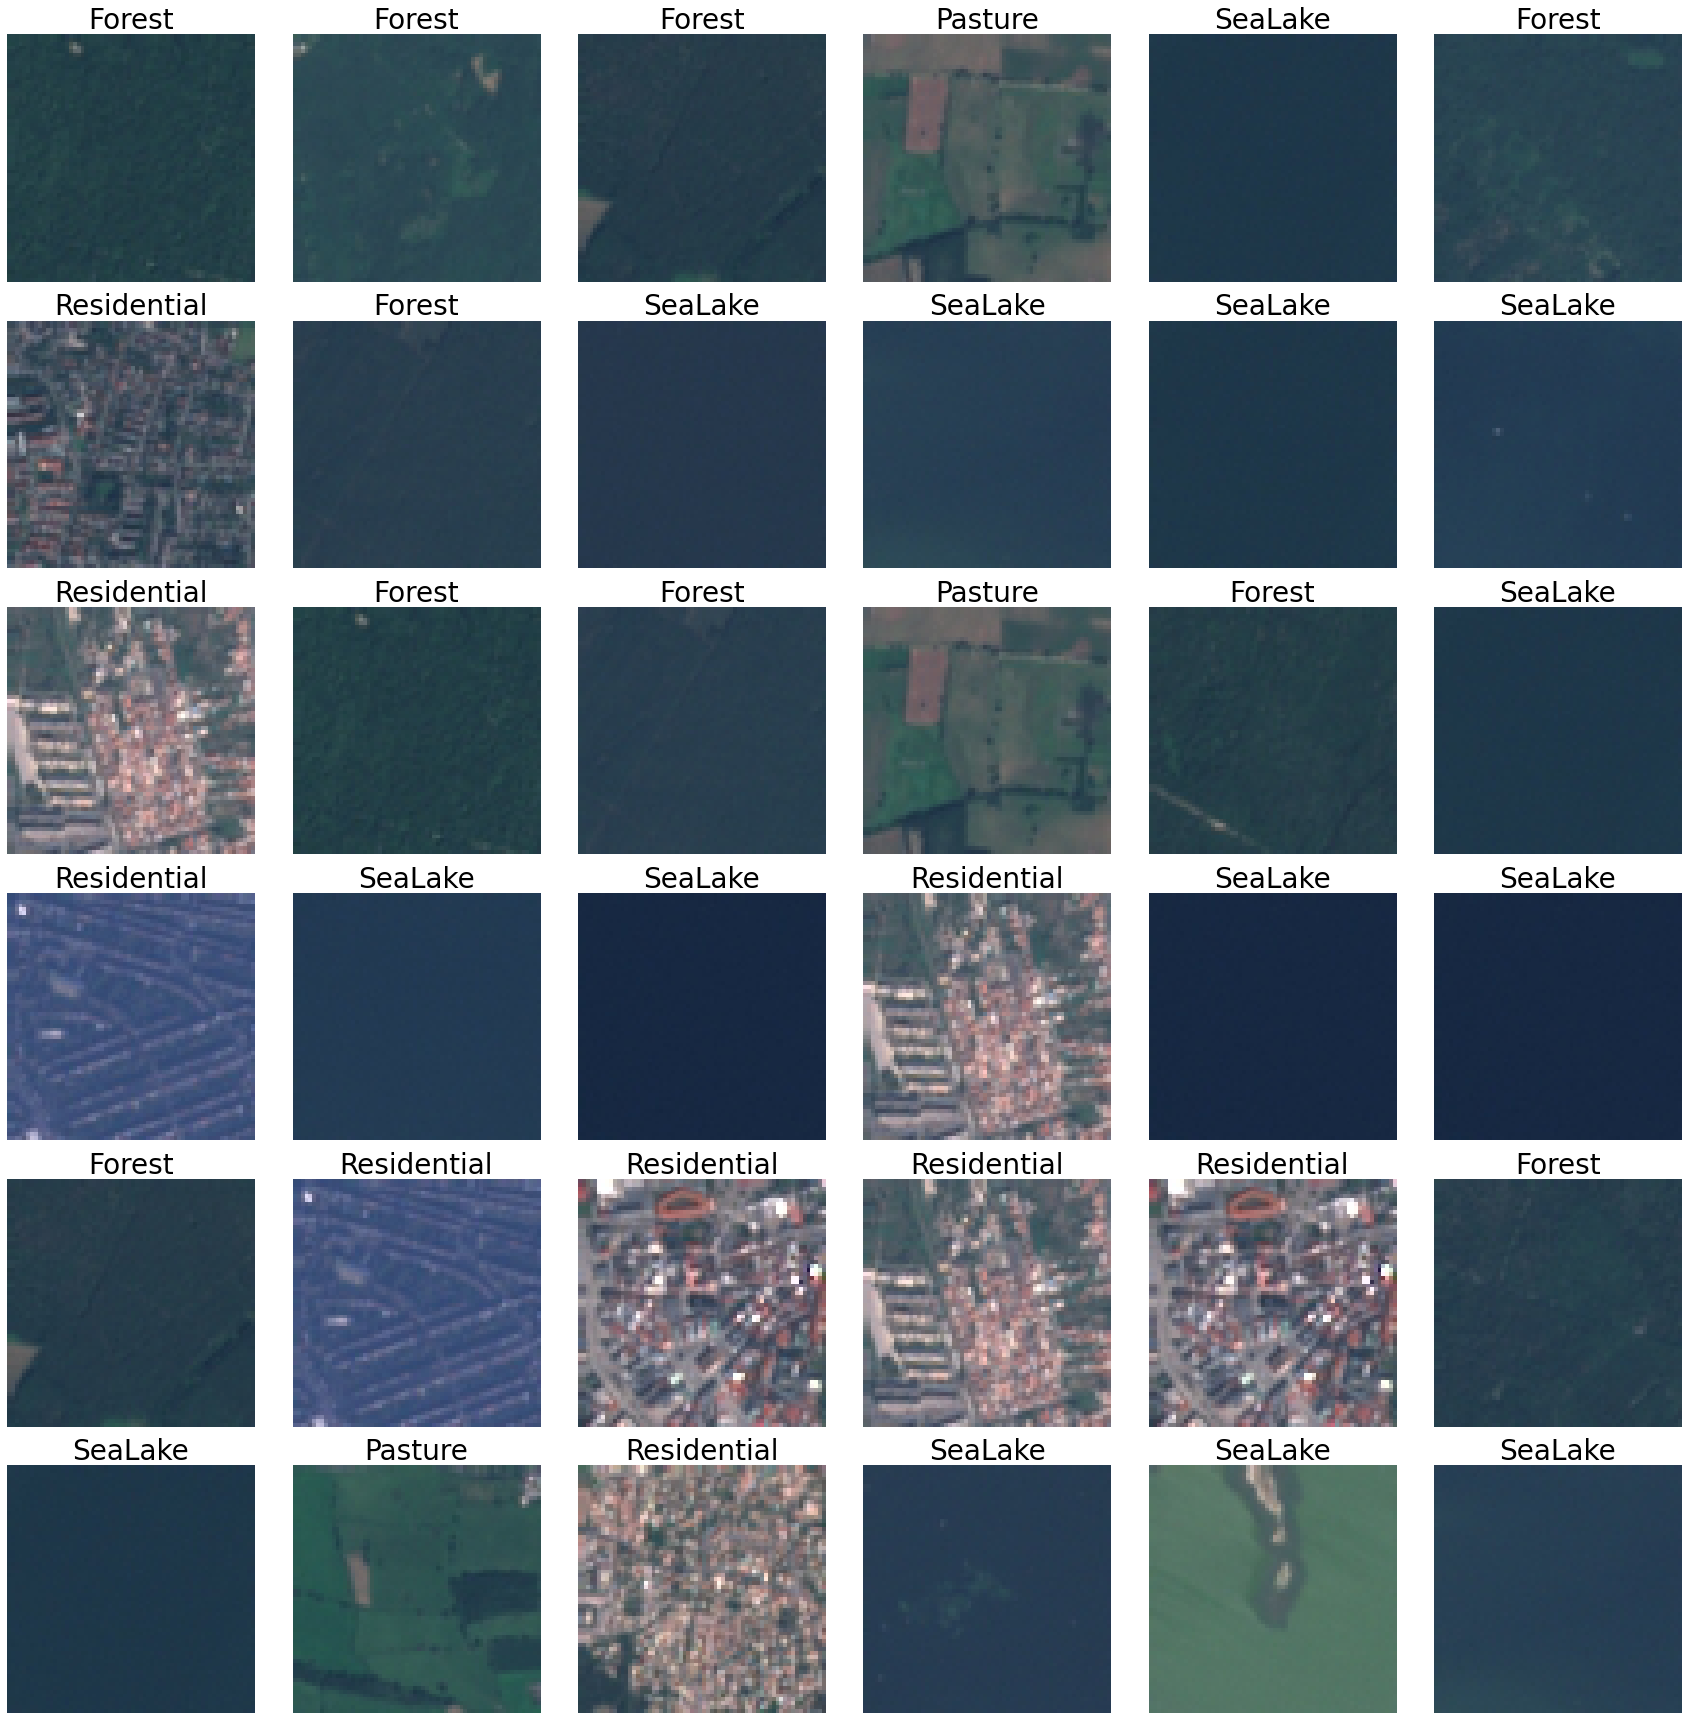

In [4]:
_ = utilities.view_images(all_paths_df, n_images=36, randomize=True).tight_layout()

In [5]:
train_paths_df, test_paths_df = train_test_split(all_paths_df, train_size=0.8, shuffle=True, random_state=4444)
train_paths_df, valid_paths_df = train_test_split(train_paths_df, train_size=0.8, shuffle=True, random_state=4444)

In [3]:
work_img_size = 112,112 # 224, 224 is default for most pretrained models
input_shape = work_img_size + (3,) # 3 for rgb (model is pretrained on rgb imgs)
batch_size = 16 # try decreasing this in case of out-of-memory errors for the GPU
n_classes = 4 # Count of classes in the dataset
EPOCHS = 100

img_datagen = ImageDataGenerator()

# Generators to import data from directories and turn it into batches.
train_data = img_datagen.flow_from_dataframe(train_paths_df,
                                               x_col='path',
                                               y_col='label',
                                               batch_size=batch_size,
                                               target_size=work_img_size,
                                               class_mode='categorical',
                                               validate_filenames=False,
                                               shuffle=True,
                                               seed=242)

valid_data = img_datagen.flow_from_dataframe(valid_paths_df,
                                               x_col='path',
                                               y_col='label',
                                               batch_size=batch_size,
                                               target_size=work_img_size,
                                               class_mode='categorical',
                                               validate_filenames=False,
                                               shuffle=False,
                                               seed=242)

test_data  =  img_datagen.flow_from_dataframe(test_paths_df,
                                               x_col='path',
                                               y_col='label',
                                               batch_size=batch_size,
                                               target_size=work_img_size,
                                               class_mode='categorical',
                                               validate_filenames=False,
                                               shuffle=False,
                                               seed=242)


NameError: name 'train_paths_df' is not defined

In [4]:
def initiate_model(core_model, prepro_layer=None, weights="imagenet",
                         input_shape=input_shape):
    """

    :param core_model:
    :param prepro_layer:
    :param weights:
    :param cb:
    :param input_shape:
    :param freeze_layers:
    :param epochs:
    :return:
    """

    i = tf.keras.layers.Input(input_shape)
    core = core_model(weights=weights,
                      include_top=False,
                      input_tensor=i)
    x = core.output
    x = tf.keras.layers.Flatten(name='flatten')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.models.Model(inputs=i, outputs=x)
    return model

In [8]:
def do_transfer_learning(core_model, prepro_layer=None, weights="imagenet", cb=[],
                         input_shape=input_shape, n_classes=2, freeze_layers=0, epochs=200):
    """

    :param core_model:
    :param prepro_layer:
    :param weights:
    :param cb:
    :param input_shape:
    :param freeze_layers:
    :param epochs:
    :return:
    """

    i = tf.keras.layers.Input(input_shape)
    core = core_model(weights=weights,
                      include_top=False,
                      input_tensor=i)
    x = core.output
    x = tf.keras.layers.Flatten(name='flatten')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    # x = tf.keras.layers.Dense(10, activation='softmax')(x)
    x = tf.keras.layers.Dense(n_classes, activation='softmax', name='fc8', kernel_initializer=RandomNormal(mean=0.0, stddev=0.001))(x)
    model = tf.keras.models.Model(inputs=i, outputs=x)
    
    # Freeze some layers
    print("Freezing the first " + str(freeze_layers) + " layers (out of " + str(len(model.layers)) + ").")
    for nr, layer in enumerate(model.layers):
        if nr < freeze_layers:
            layer.trainable = False
        else:
            layer.trainable = True
    
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), # def lr is 0.01
                  loss=tf.keras.losses.BinaryCrossentropy(), 
                  metrics=['accuracy']
               )

    hist = model.fit_generator(train_data,
                     verbose=2,
                     epochs=epochs, 
                     validation_data=valid_data,
                     callbacks= cb,
                     steps_per_epoch=len(train_data)/batch_size+1
                    )
                           
    return model, hist


In [9]:
cb1 = tf.keras.callbacks.ModelCheckpoint(CHECKPOINTS_Path+"Supervised_best_checkpoint.ckpt", monitor='val_loss', verbose=0, save_best_only=True,
                          save_weights_only=False, mode='auto', period=1)
cb2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None,
                        restore_best_weights=False)
cb_list = [cb1, cb2]


In [10]:
# strategy = tf.distribute.MirroredStrategy()
# with strategy.scope():



model_vgg16, hist_vgg16 = do_transfer_learning(tf.keras.applications.vgg16.VGG16,
                                            cb=cb_list,
                                            input_shape=input_shape,
                                            n_classes=n_classes,
                                            epochs=EPOCHS)

Freezing the first 0 layers (out of 22).
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Supervised_best_checkpoint.ckpt/assets
29/28 - 72s - loss: 0.1725 - accuracy: 0.8384 - val_loss: 0.0351 - val_accuracy: 0.9773
Epoch 2/100
29/28 - 76s - loss: 0.0821 - accuracy: 0.9440 - val_loss: 0.0661 - val_accuracy: 0.9528
Epoch 3/100
29/28 - 77s - loss: 0.1357 - accuracy: 0.9224 - val_loss: 0.1233 - val_accuracy: 0.8909
Epoch 4/100
INFO:tensorflow:Assets written to: Supervised_best_checkpoint.ckpt/assets
29/28 - 79s - loss: 0.0790 - accuracy: 0.9397 - val_loss: 0.0224 - val_accuracy: 0.9835
Epoch 5/100
INFO:tensorflow:Assets written to: Supervised_best_checkpoint.ckpt/assets
29/28 - 79s - loss: 0.0419 - accuracy: 0.9741 - val_loss: 0.0150 - val_accuracy: 0.9915
Epoch 6/100
29/28 - 71s - loss: 0.0313 - accuracy: 0.9806 - val_loss: 0.0157 - v

In [ ]:
latest = tf.train.latest_checkpoint(".")

# Evaluation

In [8]:
pd.DataFrame(hist_vgg16.history)

NameError: name 'hist_vgg16' is not defined

In [6]:
#load model

model_vgg16 = load_model("/home/nosabi/Nosheen/UCL-Multiclass/EuroSAT/Supervised/Results/4cls/Supervised_best_checkpoint.ckpt")

In [7]:
def eval_model(model, test_data=None):
    
#     hist_df = pd.DataFrame(model.history)
#     fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
#     # fig.suptitle("Accuracy and Loss")
#     ax1.plot(hist_df[["accuracy","val_accuracy"]])
#     ax1.set_title("Accuracy")
#     ax1.set_xlabel("epochs")
#     ax1.set_ylim(top=1.0)

#     ax2.plot(hist_df[["loss","val_loss"]])
#     ax2.set_title("Loss")
#     ax2.set_xlabel("epochs")
#     ax2.set_ylim(bottom=0.0)

#     fig.tight_layout()
#     plt.tight_layout()
#     plt.savefig("supervised_histories.png")
    #plt.show()
    y_probs = model.predict(test_data)
    print(np.unique(y_probs.argmax(axis=1)))
    y_preds = y_probs.argmax(axis=1) 
    print(np.unique(y_preds))

    # get the true labels from the ImageDataGenerator
    y_true = test_data.classes

    classnames = list(test_data.class_indices.keys())

#     sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_true, 
#                                                             y_preds,
#                                                             #normalize="all", # to get percentages
#                                                             cmap="Blues",
#                                                             colorbar=False,
#                                                             display_labels=classnames)
    print(np.unique(y_true))
    print(np.unique(y_preds))
    cm = sklearn.metrics.confusion_matrix(y_true, y_preds)

    disp = sklearn.metrics.ConfusionMatrixDisplay(cm, 
                                              # y_true, 
                                              # y_preds,
                                              # normalize="all", # to get percentages
                                              # colorbar=False,
                                              display_labels=classnames
                                             )
    disp = disp.plot(cmap=plt.cm.Blues,values_format='g',xticks_rotation = 'vertical')
    plt.savefig(PLOTS_Path+'confusion_Matrix.png', dpi=300)
    plt.show()
    cr = utilities.make_classification_report(y_true, y_preds, classnames)
    print(cr)
    return y_probs, y_preds

### Supervised

[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]


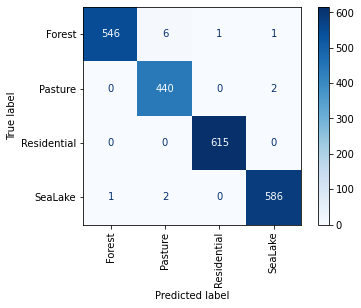

+------------- CLASSIFICATION REPORT -------------+
 accuracy 0.9941
               Precision Recall  F1-score Support
 Forest         0.9982   0.9856   0.9918   554     
 Pasture        0.9821   0.9955   0.9888   442     
 Residential    0.9984   1.0000   0.9992   615     
 SeaLake        0.9949   0.9949   0.9949   589     
 macro avg      0.9934   0.9940   0.9937   2200  
 weighted avg   0.9941   0.9941   0.9941   2200  


In [14]:
probs, preds = eval_model(model_vgg16, test_data)

# Cross Domain

### SAT6

In [16]:
work_img_size = 112,112 # 224, 224 is default for most pretrained models
input_shape = work_img_size + (3,) # 3 for rgb (model is pretrained on rgb imgs)
batch_size = 16 # try decreasing this in case of out-of-memory errors for the GPU
n_classes = 4 # Count of classes in the dataset
EPOCHS = 100

img_datagen = ImageDataGenerator()
all_paths_df = utilities.make_path_df(["/home/nosabi/Nosheen/UCL-Multiclass/SAT6_paths_4cls.txt"])
_, test_paths_df = train_test_split(all_paths_df, train_size=0.8, shuffle=True, random_state=4444)

test_data  =  img_datagen.flow_from_dataframe(test_paths_df,
                                               x_col='path',
                                               y_col='label',
                                               batch_size=batch_size,
                                               target_size=work_img_size,
                                               class_mode='categorical',
                                               validate_filenames=False,
                                               shuffle=False,

                                               seed=242)

Found 4000 non-validated image filenames belonging to 4 classes.


In [ ]:
model_vgg16 = load_model("Supervised_best_checkpoint.ckpt")

[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]


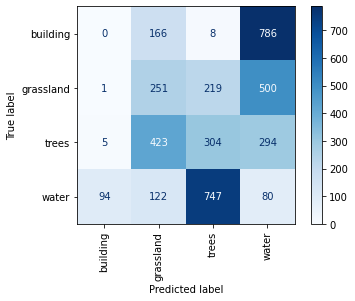

+------------- CLASSIFICATION REPORT -------------+
 accuracy 0.1588
               Precision Recall  F1-score Support
 building       0.0000   0.0000   0.0000   960     
 grassland      0.2609   0.2585   0.2597   971     
 trees          0.2379   0.2963   0.2639   1026    
 water          0.0482   0.0767   0.0592   1043    
 macro avg      0.1367   0.1579   0.1457   4000  
 weighted avg   0.1369   0.1588   0.1462   4000  


In [17]:
probs, preds = eval_model(model_vgg16, test_data)

### RSSCN7 ALL

In [11]:
work_img_size = 112,112 # 224, 224 is default for most pretrained models
input_shape = work_img_size + (3,) # 3 for rgb (model is pretrained on rgb imgs)
batch_size = 16 # try decreasing this in case of out-of-memory errors for the GPU
n_classes = 4 # Count of classes in the dataset
EPOCHS = 100

img_datagen = ImageDataGenerator()
all_paths_df = utilities.make_path_df(["/home/nosabi/Nosheen/UCL-Multiclass/RSSCN7_paths_4cls.txt"])
_, test_paths_df = train_test_split(all_paths_df, train_size=0.8, shuffle=True, random_state=4444)

test_data  =  img_datagen.flow_from_dataframe(test_paths_df,
                                               x_col='path',
                                               y_col='label',
                                               batch_size=batch_size,
                                               target_size=work_img_size,
                                               class_mode='categorical',
                                               validate_filenames=False,
                                               shuffle=False,

                                               seed=242)

Found 320 non-validated image filenames belonging to 4 classes.


In [12]:
model_vgg16 = load_model("Supervised_best_checkpoint.ckpt")

[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]


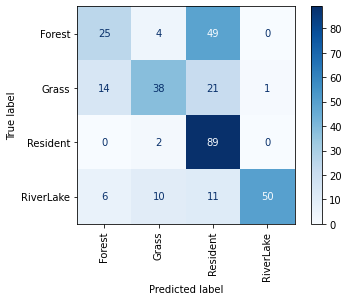

+------------- CLASSIFICATION REPORT -------------+
 accuracy 0.6312
               Precision Recall  F1-score Support
 Forest         0.5556   0.3205   0.4065   78      
 Grass          0.7037   0.5135   0.5938   74      
 Resident       0.5235   0.9780   0.6820   91      
 RiverLake      0.9804   0.6494   0.7812   77      
 macro avg      0.6908   0.6153   0.6159   320  
 weighted avg   0.6829   0.6312   0.6183   320  


In [13]:
probs, preds = eval_model(model_vgg16, test_data)

### RSSCN7 1 Res

In [30]:
work_img_size = 112,112 # 224, 224 is default for most pretrained models
input_shape = work_img_size + (3,) # 3 for rgb (model is pretrained on rgb imgs)
batch_size = 16 # try decreasing this in case of out-of-memory errors for the GPU
n_classes = 4 # Count of classes in the dataset
EPOCHS = 100

img_datagen = ImageDataGenerator()
all_paths_df = utilities.make_path_df(["/home/nosabi/Nosheen/UCL-Multiclass/RSSCN7_paths_4cls_1reslotion.txt"])
_, test_paths_df = train_test_split(all_paths_df, train_size=0.8, shuffle=True, random_state=4444)

test_data  =  img_datagen.flow_from_dataframe(test_paths_df,
                                               x_col='path',
                                               y_col='label',
                                               batch_size=batch_size,
                                               target_size=work_img_size,
                                               class_mode='categorical',
                                               validate_filenames=False,
                                               shuffle=False,

                                               seed=242)

Found 80 non-validated image filenames belonging to 4 classes.


In [31]:
#load model

model_vgg16 = load_model("/home/nosabi/Nosheen/UCL-Multiclass/EuroSAT/Supervised/Results/4cls/Supervised_best_checkpoint.ckpt")

[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]


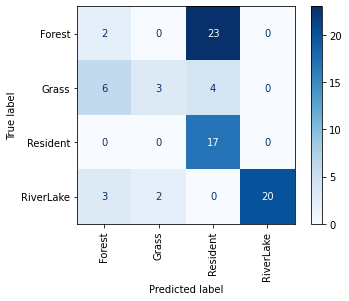

+------------- CLASSIFICATION REPORT -------------+
 accuracy 0.525
               Precision Recall  F1-score Support
 Forest         0.1818   0.0800   0.1111   25      
 Grass          0.6000   0.2308   0.3333   13      
 Resident       0.3864   1.0000   0.5574   17      
 RiverLake      1.0000   0.8000   0.8889   25      
 macro avg      0.5420   0.5277   0.4727   80  
 weighted avg   0.5489   0.5250   0.4851   80  


In [32]:
probs, preds = eval_model(model_vgg16, test_data)

### RSSCN7 2 Res

In [27]:
work_img_size = 112,112 # 224, 224 is default for most pretrained models
input_shape = work_img_size + (3,) # 3 for rgb (model is pretrained on rgb imgs)
batch_size = 16 # try decreasing this in case of out-of-memory errors for the GPU
n_classes = 4 # Count of classes in the dataset
EPOCHS = 100

img_datagen = ImageDataGenerator()
all_paths_df = utilities.make_path_df(["/home/nosabi/Nosheen/UCL-Multiclass/RSSCN7_paths_4cls_2reslotion.txt"])
_, test_paths_df = train_test_split(all_paths_df, train_size=0.8, shuffle=True, random_state=4444)

test_data  =  img_datagen.flow_from_dataframe(test_paths_df,
                                               x_col='path',
                                               y_col='label',
                                               batch_size=batch_size,
                                               target_size=work_img_size,
                                               class_mode='categorical',
                                               validate_filenames=False,
                                               shuffle=False,

                                               seed=242)

Found 80 non-validated image filenames belonging to 4 classes.


In [28]:
#load model

model_vgg16 = load_model("/home/nosabi/Nosheen/UCL-Multiclass/EuroSAT/Supervised/Results/4cls/Supervised_best_checkpoint.ckpt")

[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]


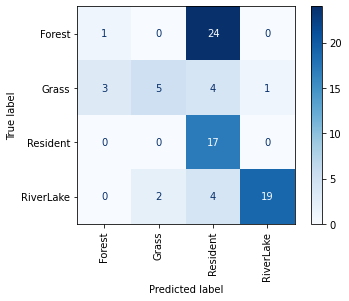

+------------- CLASSIFICATION REPORT -------------+
 accuracy 0.525
               Precision Recall  F1-score Support
 Forest         0.2500   0.0400   0.0690   25      
 Grass          0.7143   0.3846   0.5000   13      
 Resident       0.3469   1.0000   0.5152   17      
 RiverLake      0.9500   0.7600   0.8444   25      
 macro avg      0.5653   0.5462   0.4821   80  
 weighted avg   0.5648   0.5250   0.4762   80  


In [29]:
probs, preds = eval_model(model_vgg16, test_data)

### RSSCN7 3 Res

In [21]:
work_img_size = 112,112 # 224, 224 is default for most pretrained models
input_shape = work_img_size + (3,) # 3 for rgb (model is pretrained on rgb imgs)
batch_size = 16 # try decreasing this in case of out-of-memory errors for the GPU
n_classes = 4 # Count of classes in the dataset
EPOCHS = 100

img_datagen = ImageDataGenerator()
all_paths_df = utilities.make_path_df(["/home/nosabi/Nosheen/UCL-Multiclass/RSSCN7_paths_4cls_3reslotion.txt"])
_, test_paths_df = train_test_split(all_paths_df, train_size=0.8, shuffle=True, random_state=4444)

test_data  =  img_datagen.flow_from_dataframe(test_paths_df,
                                               x_col='path',
                                               y_col='label',
                                               batch_size=batch_size,
                                               target_size=work_img_size,
                                               class_mode='categorical',
                                               validate_filenames=False,
                                               shuffle=False,

                                               seed=242)

Found 80 non-validated image filenames belonging to 4 classes.


In [22]:
#load model

model_vgg16 = load_model("/home/nosabi/Nosheen/UCL-Multiclass/EuroSAT/Supervised/Results/4cls/Supervised_best_checkpoint.ckpt")

[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]


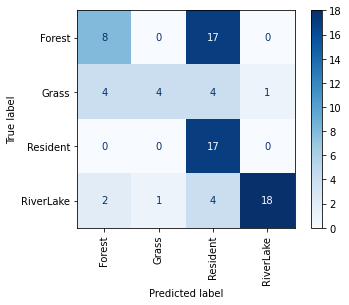

+------------- CLASSIFICATION REPORT -------------+
 accuracy 0.5875
               Precision Recall  F1-score Support
 Forest         0.5714   0.3200   0.4103   25      
 Grass          0.8000   0.3077   0.4444   13      
 Resident       0.4048   1.0000   0.5763   17      
 RiverLake      0.9474   0.7200   0.8182   25      
 macro avg      0.6809   0.5869   0.5623   80  
 weighted avg   0.6906   0.5875   0.5786   80  


In [23]:
probs, preds = eval_model(model_vgg16, test_data)

### RSSCN7 4 Res

In [18]:
work_img_size = 112,112 # 224, 224 is default for most pretrained models
input_shape = work_img_size + (3,) # 3 for rgb (model is pretrained on rgb imgs)
batch_size = 16 # try decreasing this in case of out-of-memory errors for the GPU
n_classes = 4 # Count of classes in the dataset
EPOCHS = 100

img_datagen = ImageDataGenerator()
all_paths_df = utilities.make_path_df(["/home/nosabi/Nosheen/UCL-Multiclass/RSSCN7_paths_4cls_4reslotion.txt"])
_, test_paths_df = train_test_split(all_paths_df, train_size=0.8, shuffle=True, random_state=4444)

test_data  =  img_datagen.flow_from_dataframe(test_paths_df,
                                               x_col='path',
                                               y_col='label',
                                               batch_size=batch_size,
                                               target_size=work_img_size,
                                               class_mode='categorical',
                                               validate_filenames=False,
                                               shuffle=False,

                                               seed=242)

Found 80 non-validated image filenames belonging to 4 classes.


In [19]:
#load model

model_vgg16 = load_model("/home/nosabi/Nosheen/UCL-Multiclass/EuroSAT/Supervised/Results/4cls/Supervised_best_checkpoint.ckpt")

[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]


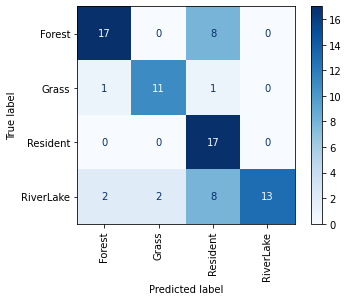

+------------- CLASSIFICATION REPORT -------------+
 accuracy 0.725
               Precision Recall  F1-score Support
 Forest         0.8500   0.6800   0.7556   25      
 Grass          0.8462   0.8462   0.8462   13      
 Resident       0.5000   1.0000   0.6667   17      
 RiverLake      1.0000   0.5200   0.6842   25      
 macro avg      0.7990   0.7615   0.7381   80  
 weighted avg   0.8219   0.7250   0.7291   80  


In [20]:
probs, preds = eval_model(model_vgg16, test_data)

### UCMerced_Landuse

In [7]:
work_img_size = 112,112 # 224, 224 is default for most pretrained models
input_shape = work_img_size + (3,) # 3 for rgb (model is pretrained on rgb imgs)
batch_size = 16 # try decreasing this in case of out-of-memory errors for the GPU
n_classes = 4 # Count of classes in the dataset
EPOCHS = 100

img_datagen = ImageDataGenerator()
test_paths_df = utilities.make_path_df(["/home/nosabi/Nosheen/UCL-Multiclass/UCMerced_LandUse_paths_4cls.txt"])
_, test_paths_df = train_test_split(all_paths_df, train_size=0.8, shuffle=True, random_state=4444)

test_data  =  img_datagen.flow_from_dataframe(test_paths_df,
                                               x_col='path',
                                               y_col='label',
                                               batch_size=batch_size,
                                               target_size=work_img_size,
                                               class_mode='categorical',
                                               validate_filenames=False,
                                               shuffle=False,

                                               seed=242)

Found 80 non-validated image filenames belonging to 4 classes.


In [5]:
model_vgg16 = load_model("Results/4cls/Supervised_best_checkpoint.ckpt")

[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]


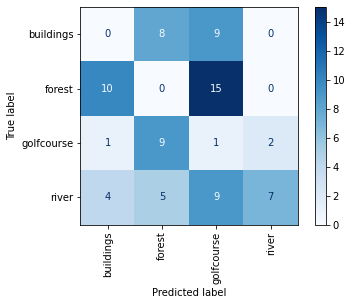

+------------- CLASSIFICATION REPORT -------------+
 accuracy 0.1
               Precision Recall  F1-score Support
 buildings      0.0000   0.0000   0.0000   17      
 forest         0.0000   0.0000   0.0000   25      
 golfcourse     0.0294   0.0769   0.0426   13      
 river          0.7778   0.2800   0.4118   25      
 macro avg      0.2018   0.0892   0.1136   80  
 weighted avg   0.2478   0.1000   0.1356   80  


In [8]:
probs, preds = eval_model(model_vgg16, test_data)